In [49]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import matplotlib.pyplot as plt

from time import time
from scipy.sparse import csr_matrix, dok_matrix, diags
from scipy.sparse.linalg import svds
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, classification_report

import tensorflow as tsf

#### First separate the data into a training and test set

In [2]:
df = pd.read_csv("data/emails.csv")
X = df.Text
y = df.Spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Now we will process the data into a TF-IDF matrix format

- Start with getting the set of all words, and pre-process the text strings into lists of words

In [3]:
def get_words(document: list[list[str]]):
    for word in nltk.tokenize.word_tokenize(document):
        if word not in string.punctuation:
            yield word.lower()

In [4]:
def process_documents(data):
    all_words = {}; index = 0
    emails = []
    
    for email in data:
        current = []
        for word in get_words(email):
            if word not in all_words:
                all_words|= {word:index}
                index+=1
            current.append(word)
        emails.append(current)
    return all_words, emails


def process_test_documents(data, all_words):
    emails = []
    for email in data:
        current = []
        for word in get_words(email):
            if word in all_words:
                current.append(word)
        emails.append(current)
    return emails

In [5]:
all_words, emails = process_documents(X_train)

In [7]:
with open("data/emails.pickle", "wb") as f:
    pickle.dump((all_words, emails), f)

- With the data preprocessed we can easily compute the TF IDF with the following functions

In [8]:
def count_words(
    words: list[str]
) -> dict[str, int]:
    """
    Counts the ocurrence of each word in the document corpus.
    """
    return dict(zip(*np.unique(words, return_counts=True)))


def tf(
    word_counts: dict[str, int], 
    i: int,
    all_words: dict[str, int], 
    TF_Matrix: dok_matrix
) -> None:
    """
    Computes the Term-Frequency vector of a document. 
    Operates in-memory in the Term-Frequency Matrix, receiving the index {i} that corresponds to the document.
    """
    counts = word_counts.values()
    if len(counts)==0: return {}
    max_value = max(counts)
    
    for word, counts in word_counts.items():
        TF_Matrix[i, all_words[word]] = counts/max_value
    
    
def calc_sparse_tf_matrix(
    docs: list[list[str]], 
    all_words: dict[str, int], 
    TF_Matrix:dok_matrix
)->dok_matrix:
    """
    Computes the Term-Frequency Matrix
    """
    for i, doc in enumerate(docs):
        word_counts = count_words(doc)
        tf(word_counts, i, all_words, TF_Matrix)
    return TF_Matrix

In [9]:
def calc_idf(
    documents: list[list[str]],
    all_words: dict[str, int],
    IDF_Matrix: dok_matrix
) -> dok_matrix:
    """
    Computes the Inverse Document Frequency in-memory.
    """
    N = len(documents)
    
    for doc in documents:
        for word in np.unique(doc):
            IDF_Matrix[ 0, all_words[word] ] += 1
    
    for i in range(IDF_Matrix.shape[1]):
        IDF_Matrix[0, i] = np.log2(N / (IDF_Matrix[0, i] + 1) ) + 1
    return IDF_Matrix

In [10]:
def calc_tf_idf(
    all_words: dict[str, int],
    documents: list[list[str]]
) -> dok_matrix :
    """
    Calculates TF-IDF matrix
    """
    N = len(documents)
    M = len(all_words)
    
    TF = dok_matrix(np.zeros( (N, M) ))
    IDF = dok_matrix(np.zeros( (1, M) ))
    
    TF = calc_sparse_tf_matrix(documents, all_words, TF).tocsr()
    IDF = calc_idf(documents, all_words, IDF).tocsr()
    
    print("TF size =", sys.getsizeof(pickle.dumps(TF))/1024**2, "MB")
    print("IDF size =", sys.getsizeof(pickle.dumps(IDF))/1024**2, "MB")
    
    TF_IDF = TF.multiply(IDF)
    return TF_IDF

In [11]:
TF_IDF = calc_tf_idf(all_words, emails)

TF size = 6.801630973815918 MB
IDF size = 0.38732337951660156 MB


### Now we will train the model with the sparse matrix and check the results

First we will use the full dataset

Afterwards the data will be decomposed using SVD to reduce dimensionality and the process will be repeated


#### Using Full dataset
    - SVM

In [10]:
svm = SVC(kernel="linear").fit(TF_IDF, y_train)

In [11]:
svm.score(TF_IDF, y_train)

1.0

In [12]:
test_words = process_test_documents(X_test, all_words)

In [13]:
TF_IDF_test = calc_tf_idf(all_words, test_words)

TF size = 1.6422529220581055 MB
IDF size = 0.38732337951660156 MB


MCC = 0.9751002951582475
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       885
           1       0.99      0.97      0.98       261

    accuracy                           0.99      1146
   macro avg       0.99      0.98      0.99      1146
weighted avg       0.99      0.99      0.99      1146



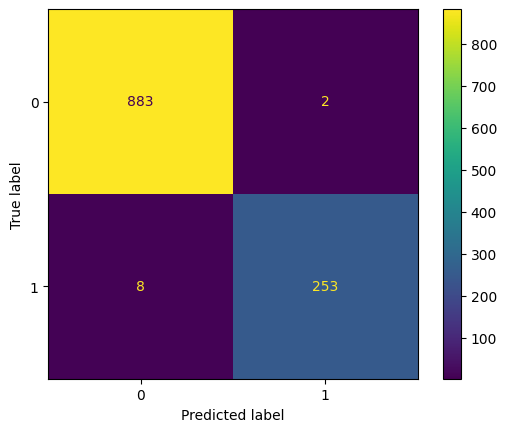

In [14]:
preds = svm.predict(TF_IDF_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

 - Random Forest

In [15]:
rfc = RandomForestClassifier().fit(TF_IDF, y_train)
rfc.score(TF_IDF, y_train)

1.0

MCC = 0.902592838391271
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       885
           1       1.00      0.85      0.92       261

    accuracy                           0.97      1146
   macro avg       0.98      0.93      0.95      1146
weighted avg       0.97      0.97      0.96      1146



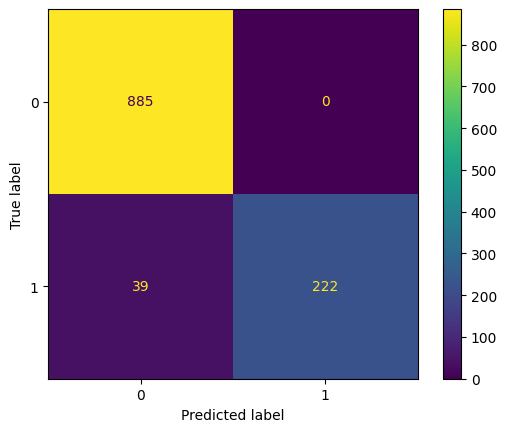

In [16]:
preds = rfc.predict(TF_IDF_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

#### Reducing Noise using SVD

In [10]:
TF_IDF

<4582x33811 sparse matrix of type '<class 'numpy.float64'>'
	with 592774 stored elements in Compressed Sparse Row format>

##### Selecting how many components to represent 90% of the data

In [11]:
s = np.linalg.svd(TF_IDF.toarray(), compute_uv=False)

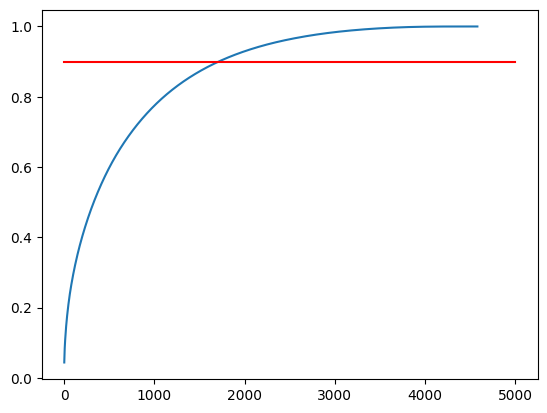

In [14]:
plt.plot(np.cumsum(s**2/(s**2).sum()))
plt.plot([0, 5000], [0.9, 0.9], "r")

In [18]:
s[(np.cumsum( (s**2)/(s**2).sum() )<=0.9)].shape

(1712,)

In [19]:
np.cumsum(((s**2)/(s**2).sum()))[1712]

0.9001052236798228

##### Computing the Reduced SVC

In [12]:
u,s,v = svds(TF_IDF.tocsr(), k=1712)

In [13]:
TF_IDF.shape

(4582, 33811)

In [14]:
u.shape, np.diag(s).shape, v.shape

((4582, 1712), (1712, 1712), (1712, 33811))

In [28]:
(500*1712)

856000

In [29]:
4582*1712

7844384

In [30]:
u, s, v = tsf.convert_to_tensor(u), tsf.convert_to_tensor(s), tsf.convert_to_tensor(v)

In [19]:
u.shape, s.shape, v.shape

(TensorShape([4582, 1712]), TensorShape([1712]), TensorShape([1712, 33811]))

In [37]:
SVD_tfidf = csr_matrix(u @ tsf.linalg.diag(s) @ v)

In [38]:
SVD_tfidf

<4582x33811 sparse matrix of type '<class 'numpy.float64'>'
	with 154922002 stored elements in Compressed Sparse Row format>

- SVM

In [39]:
svm = SVC(kernel="linear").fit(SVD_tfidf, y_train)
svm.score(SVD_tfidf, y_train)

1.0

In [40]:
TF_IDF_test = calc_tf_idf(
    all_words, 
    process_test_documents(X_test, all_words)
)

TF size = 1.6422529220581055 MB
IDF size = 0.38732337951660156 MB


MCC = 0.9651883406692926
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       885
           1       0.98      0.97      0.97       261

    accuracy                           0.99      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



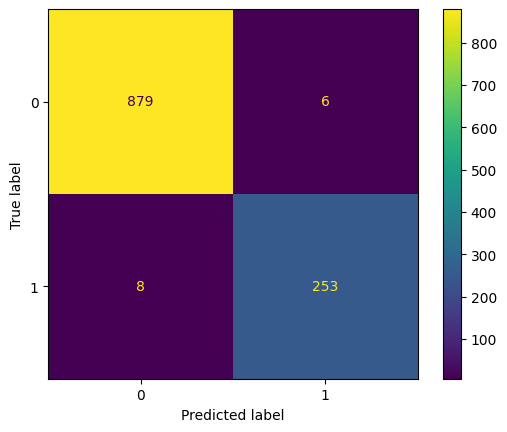

In [41]:
preds = svm.predict(TF_IDF_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

By reducing the space to 90% concept explainability, we can see that the model did not perform as well as before. It did not misclassified any of the non-spam emails, but classified wrongly half of the spam as non-spam. <br>

[comment]: <> (What suffered more impact was the False Positives.)

In [44]:
rfc = RandomForestClassifier().fit(SVD_tfidf, y_train)
rfc.score(SVD_tfidf, y_train)

1.0

MCC = 0.5447222598671126
              precision    recall  f1-score   support

           0       0.99      0.66      0.80       885
           1       0.46      0.98      0.63       261

    accuracy                           0.74      1146
   macro avg       0.73      0.82      0.71      1146
weighted avg       0.87      0.74      0.76      1146



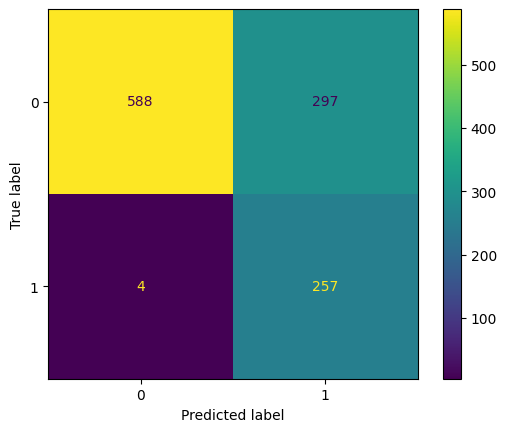

In [45]:
preds = rfc.predict(TF_IDF_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()